In [1]:
#data packages:
import pandas as pd
import numpy as np
from scipy import stats
import random
#plot packages:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#neural network packages:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.advanced_activations import ELU, LeakyReLU

Using TensorFlow backend.
/home/john/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## 1. The Dataset
This sample dataset gives event reports from an on-demand hiring service. From the assignment text: **'we want to use market data to build a model that suggests hourly rates to Taskers that would maximize their opportunity to be hired.'** My goal is to produce a machine learning model which determines likelihood of hire for a tasker, given the sample dataset. In this Notebook I approach this with a grid parameter search using Keras and Tensorflow.

You can also find this notebook hosted [here](https://github.com/JCMontalbano/rabbit).

### 1.1 Exploring the dataset
The dataset looks like this:

In [2]:
DF=pd.read_csv('sample.csv')
DF[:20]

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1006892359,2,40,193,0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1012023956,3,28,0,0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009733517,4,43,303,0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1013579273,5,29,39,0,Furniture Assembly
5,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1012043028,6,28,2,0,Furniture Assembly
6,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1013470741,7,29,9,0,Furniture Assembly
7,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009557645,8,29,8,0,Furniture Assembly
8,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1010800768,9,28,0,0,Furniture Assembly
9,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009072269,10,35,59,0,Furniture Assembly


The dataset includes sets of bids, in groups of 15. These bids are indexed by unique task IDs in the 'recommendation_id' category. For each tasker, the independent variables are hourly rate (actively set by the tasker), number of completed tasks (not immediately influenced by the tasker), and job category. The dependent variable is a binary, 'hired'.

Each unique recommendation_id is associated with 15 'bids', from which the customer selects one tasker. As you can see, in rows 15-19 the recommendation_id has changed, and the 'position' variable resets at 1.
The assignment stipulates that the tasker has no control over their position in the ranking, therefore I chose not to model that part of the problem. Likewise the tasker has no immediate control over their personal number of completed tasks; they can only change their bid. 

Therefore, assuming that the customers are comparing the 15 taskers in their recommendation, I thought we might be able to compare numbers within each bid, to further predict the hiring likelihood for each tasker in the context of each job. 

### 1.2 Expressing hourly_rate and num_completed_tasks proportionally to the mean and max within that recommendation set
I added four new columns to the dataset, which express the user's bid relative the 15-person recommendation set they occurred in: user's hourly_rate as a fraction of the mean and max hourly_rates in that recommendation, and user's num_completed_tasks as a fraction of the mean and max completed tasks in their recommendation. To do this I separated the dataset by recommendation (remember, each 'recommendation' is a group of 15) and calculated each tasker's hourly_rate and num_completed_tasks as a ratio to the max and mean of those values, within that recommendation. I then added the resulting four new columns to the dataset.
At the end I confirm proportionality by checking that the average of the mean fractions is ~=1, and then print the first recommendation from the dataset. As you can see, it remains unchanged except for the four new columns.

In [3]:
#There are ~15 recommendations for each recommendation_id, so it can index groupings
len(DF)/len(set(DF.recommendation_id))

14.285714285714286

However, the python set() function doesn't keep the order in which the recommendations occur in the DF, so we must take them by iterating the rows:

In [4]:
#generate the recommendation_id list from the DF:
reclist=[]
for row in DF.iterrows():
	recID=row[1][0]
	if recID not in reclist:
		reclist.append(recID)

Now we generate the new columns and add them to the dataset:

In [5]:
#initialize lists
t_meanratelist=[]
t_maxratelist=[]
t_meancomplist=[]
t_maxcomplist=[]

for recommendation in reclist:
    subDF=DF[DF['recommendation_id']==recommendation]
    meanrate=subDF.hourly_rate.mean()
    maxrate=subDF.hourly_rate.max()
    meancomp=subDF.num_completed_tasks.mean()
    maxcomp=subDF.num_completed_tasks.max()	
    for tasker in subDF.iterrows():
        t_rate=tasker[1][4]
        t_meanrate=(t_rate)/meanrate
        t_maxrate=(t_rate)/maxrate
        t_meanratelist.append(t_meanrate)
        t_maxratelist.append(t_maxrate)
        t_comp=tasker[1][5]
        t_meancomp=(t_comp)/meancomp
        t_maxcomp=(t_comp)/maxcomp
        t_meancomplist.append(t_meancomp)
        t_maxcomplist.append(t_maxcomp)
        
#include the vectorized lists into the original DF as columns:
DF['meanrate']=t_meanratelist
DF['maxrate']=t_maxratelist
DF['meancomp']=t_meancomplist
DF['maxcomp']=t_maxcomplist

In [6]:
#confirm that the proportionality is working:
print('Average of mean-rate column: '+str(np.mean(DF.meanrate)))
print('Average of max-rate column: '+str(np.mean(DF.meancomp)))

Average of mean-rate column: 0.999999999999993
Average of max-rate column: 0.9999999999999957


In [7]:
DF[:5]

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category,meanrate,maxrate,meancomp,maxcomp
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009185352,1,38,151,0,Furniture Assembly,1.144578,0.76,1.281109,0.165208
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1006892359,2,40,193,0,Furniture Assembly,1.204819,0.80,1.637443,0.211160
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1012023956,3,28,0,0,Furniture Assembly,0.843373,0.56,0.000000,0.000000
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009733517,4,43,303,0,Furniture Assembly,1.295181,0.86,2.570701,0.331510
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1013579273,5,29,39,0,Furniture Assembly,0.873494,0.58,0.330882,0.042670


### 1.3 Point-biserial tests of significance for each independent variable
Are the new metrics really more meaningful predictors than the old ones alone? Let's compare their correlations. The scipy.stats.pointbiserialr() function returns a correlation value, r, as well as a p-value for a two-tailed p-value test. Higher correlation is better, lower p-value is better. As you can see, the p-values for the proportional values are very small; these values do indeed predict the difference between the 'hired' and 'not hired' groups.

In [8]:
print(stats.pointbiserialr(DF.meanrate,DF.hired))
print(stats.pointbiserialr(DF.maxrate,DF.hired))
print(stats.pointbiserialr(DF.meancomp,DF.hired))
print(stats.pointbiserialr(DF.maxcomp,DF.hired))

PointbiserialrResult(correlation=-0.070082274983476064, pvalue=5.5268594141237121e-34)
PointbiserialrResult(correlation=-0.054077442207914481, pvalue=7.0529139912511035e-21)
PointbiserialrResult(correlation=0.053839248689665192, pvalue=1.0427384475296692e-20)
PointbiserialrResult(correlation=0.060609138630314863, pvalue=8.017631159830535e-26)


But do they predict the difference more than the raw values alone? Let's run the point-biserial p-test for the 'hired' category against the hourly_rate and num_completed_tasks columns:

In [9]:
print(stats.pointbiserialr(DF.hourly_rate,DF.hired))
print(stats.pointbiserialr(DF.num_completed_tasks,DF.hired))

PointbiserialrResult(correlation=-0.046519106252867579, pvalue=7.5441719622639566e-16)
PointbiserialrResult(correlation=0.041824885364732889, pvalue=4.2562678973772039e-13)


As you can see, the p-values for the proportional weights are far smaller than the p-values for the raw weights. **Because all of these p-values are far below .05, we reject the null hypothesis for each of these variables.** Because the p-values of the group-proportional weights are 10^10 to 10^21 smaller than those for the unprocessed weights, we can conclude that the process adds useful information to the model.

### 1.4 Splitting the datasets by category:
Having produced the additional vectors, can we find whether the separate job categories are differently correlated by these metrics? Let's find out. First we split the DF into three subDFs, one for each category, then we run the same correlations from above within each:

In [10]:
furnitureDF=DF[DF['category']=='Furniture Assembly']
moveDF=DF[DF['category']=='Moving Help']
mountDF=DF[DF['category']=='Mounting']
list(set(DF.category))

['Mounting', 'Moving Help', 'Furniture Assembly']

In [91]:
DFcorrelates=[
stats.pointbiserialr(DF.hourly_rate,DF.hired)[0],
stats.pointbiserialr(DF.meanrate,DF.hired)[0],
stats.pointbiserialr(DF.maxrate,DF.hired)[0],
stats.pointbiserialr(DF.num_completed_tasks,DF.hired)[0],
stats.pointbiserialr(DF.meancomp,DF.hired)[0],
stats.pointbiserialr(DF.maxcomp,DF.hired)[0]
]
                    
moveDFcorrelates=[
stats.pointbiserialr(moveDF.hourly_rate,moveDF.hired)[0],
stats.pointbiserialr(moveDF.meanrate,moveDF.hired)[0],
stats.pointbiserialr(moveDF.maxrate,moveDF.hired)[0],
stats.pointbiserialr(moveDF.num_completed_tasks,moveDF.hired)[0],
stats.pointbiserialr(moveDF.meancomp,moveDF.hired)[0],
stats.pointbiserialr(moveDF.maxcomp,moveDF.hired)[0]
]
                  
mountDFcorrelates=[
stats.pointbiserialr(mountDF.hourly_rate,mountDF.hired)[0],
stats.pointbiserialr(mountDF.meanrate,mountDF.hired)[0],
stats.pointbiserialr(mountDF.maxrate,mountDF.hired)[0],
stats.pointbiserialr(mountDF.num_completed_tasks,mountDF.hired)[0],
stats.pointbiserialr(mountDF.meancomp,mountDF.hired)[0],
stats.pointbiserialr(mountDF.maxcomp,mountDF.hired)[0]
]

furnitureDFcorrelates=[
stats.pointbiserialr(furnitureDF.hourly_rate,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.meanrate,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.maxrate,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.num_completed_tasks,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.meancomp,furnitureDF.hired)[0],
stats.pointbiserialr(furnitureDF.maxcomp,furnitureDF.hired)[0]
]
x=np.arange(len(DFcorrelates))

### 1.5 Plotting point-biserial correlation of each column for each variable:

In [97]:
plt.close()
# plot data
# use zorder to put bars in front of grid
bar_width=0.15
plt.bar(x,DFcorrelates,width=bar_width,color='green',zorder=2)
plt.bar(x+bar_width, moveDFcorrelates, width=bar_width, color='red', zorder=2)
plt.bar(x+bar_width*2, mountDFcorrelates, width=bar_width, color='orange', zorder=2)
plt.bar(x+bar_width*3, furnitureDFcorrelates, width=bar_width, color='blue', zorder=2)

# labels
plt.xticks(x+bar_width*2, ['hourly_rate','meanrate','maxrate','num_completed_tasks','meancomp','maxcomp'])
plt.title('Point-biserial correlation of variables to hired axis:')
plt.xlabel('column name')
plt.ylabel('point-biserial r')

#legend
green_patch=mpatches.Patch(color='green',label='DF')
red_patch=mpatches.Patch(color='red',label='moveDF')
orange_patch=mpatches.Patch(color='orange',label='mountDF')
blue_patch=mpatches.Patch(color='blue',label='furnitureDF')
plt.legend(handles=[green_patch,red_patch,orange_patch,blue_patch])

#grid
plt.grid(axis='y')

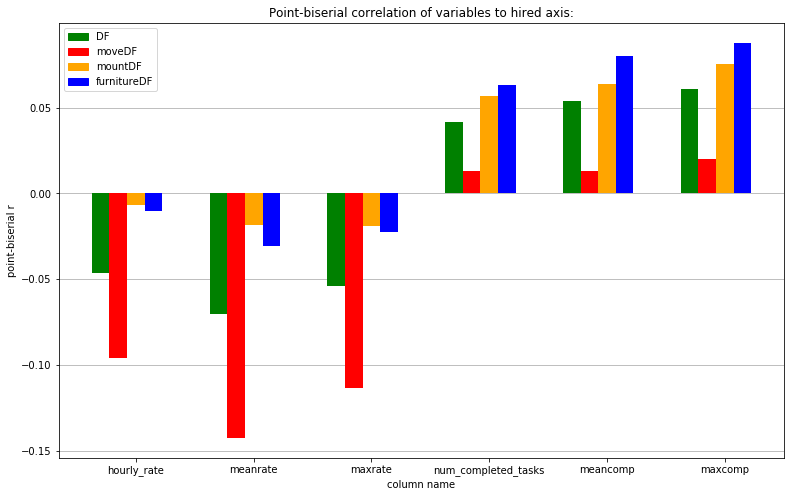

In [98]:
plt.rcParams['figure.figsize'] = [15, 7]
plt.show()

*if the above chart looks small, refresh it by running the above two code cells*

* As you can see, the 'completed_tasks' metrics are stronger predictors of hire for 'mounting' and 'furniture assembly' categories. Conversely, the rate metrics are by far the largest predictor for moving.
*  Unsurprisingly, the correlation between hourly_rate and hired is always negative, and the correlation between num_completed_tasks and hired is always positive. 
* Finally, even though the correlation for the group-ratio measures are larger, they follow similar direction and scale to the raw values.

In [14]:
plt.close()

## 2. Training a neural network to predict 'hired' from tasker variables

This might be a good problem for an artificial neural network. The correlations are clear, but they change based on category. The neural network will find the appropriate and relevant weights and measures between the independent variables (rate and task completed measures) and the dependent variable, 'hired'.

### 2.1 the Training Dataset
We'll need to convert the data we're keeping to numbers. We can neglect ID values, and the timestamp. By converting 'category' from string to number, we can train a neural network to classify bids as 'hired' or 'not hired'. Because there are only three categories, it's easy enough to hardcode them.

In [15]:
trainDF=DF.drop(['tasker_id','recommendation_id','created_at','position'], axis=1)
categorylist=[]


for row in DF.iterrows(): 
    if row[1][7]=='Moving Help':
        categorylist.append(0)
    if row[1][7]=='Mounting':
        categorylist.append(1)
    if row[1][7]=='Furniture Assembly':
        categorylist.append(2)

trainDF.category=categorylist

trainDF[:5]

,hourly_rate,num_completed_tasks,hired,category,meanrate,maxrate,meancomp,maxcomp
0,38,151,0,2,1.144578,0.76,1.281109,0.165208
1,40,193,0,2,1.204819,0.80,1.637443,0.211160
2,28,0,0,2,0.843373,0.56,0.000000,0.000000
3,43,303,0,2,1.295181,0.86,2.570701,0.331510
4,29,39,0,2,0.873494,0.58,0.330882,0.042670


### 2.2 Training the neural network without class balancing; a 'dying neuron' story

To train a neural network, we sample a set of the data to be a training dataset, and hold out the remainder as a validation dataset. To minimize overfitting our model, we minimize variance, meaning we keep the network model with the highest validation accuracy. I've included a few likely network sizes in layerslist and nodeslist, and automated the building and training of a neural network given these parameters. 

In [16]:
#function for training the network:
def TrainNet(TargetDF, layers, nodes, epochs, activator, lossfcn):
	target=to_categorical(TargetDF[targetcolumn])
	predictors=TargetDF.drop([targetcolumn], axis=1).as_matrix()
	n_cols=predictors.shape[1]
	model=Sequential()
	model.add(Dense(nodes,activation=activator,input_shape=(n_cols,)))
	for layer in range(0,layers):
		model.add(Dense(nodes,activation=activator))
	model.add(Dense(2,activation='softmax'))
	model.compile(optimizer='adam',loss=lossfcn, metrics=['categorical_accuracy'])
	model_training=model.fit(predictors,target, validation_split=0.7, epochs=epochs, shuffle=True, callbacks=[earlystopping], verbose=1)
	val_acc=model_training.history['val_categorical_accuracy'][-1]
	return(model,val_acc)

In [17]:
#variables for the neural network
targetcolumn='hired'
layerslist=[2,5,10] #these need to hold the series of parameters we know tend to find solutions
nodeslist=[25,50,100]
epochs=10
activator='relu'
lossfcn='categorical_crossentropy' 

We compare several different parameter sets, to find the best network configuration. The following commands automate the parameter grid search:  
`targetnets=len(layerslist)*len(nodeslist)`  
`while total_nets<targetnets`

In [20]:
total_nets=0
targetnets=len(layerslist)*len(nodeslist)
targetacc=0
accrecord1=[]
netnamesrecord1=[]
targetaccrecord1=[]

earlystopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

#parameter search through layers and nodes values, keeping the model with the highest validation accuracy
while total_nets<targetnets:
	for layers in layerslist:
		for nodes in nodeslist:
			net_name=(str(layers)+'.'+str(nodes)+'.'+'relu')
			print(str(total_nets)+'/'+str(targetnets)+' complete. Next net: '+str(layers)+' layers, '+str(nodes)+' nodes.')
			model,val_acc=TrainNet(trainDF, layers, nodes, epochs, activator, lossfcn)
			if val_acc>(targetacc): #if acc>target, name and save it and new_net=Tru
				targetacc=val_acc
				print('This network improved accuracy, new target accuracy is '+str(targetacc))
				finalmodel1=model
				finalmodel1name=net_name
			else: 
				del model
				print('Nope')
			netnamesrecord1.append(net_name)
			accrecord1.append(val_acc)
			targetaccrecord1.append(targetacc)                
			total_nets+=1

0/9 complete. Next net: 2 layers, 25 nodes.
Train on 9000 samples, validate on 21000 samples
Epoch 1/10
9000/9000 [==============================] - 1s - loss: 0.3861 - categorical_accuracy: 0.9266 - val_loss: 0.2481 - val_categorical_accuracy: 0.9430
Epoch 2/10
9000/9000 [==============================] - 1s - loss: 0.2399 - categorical_accuracy: 0.9428 - val_loss: 0.2528 - val_categorical_accuracy: 0.9430
Epoch 3/10
9000/9000 [==============================] - 1s - loss: 0.2426 - categorical_accuracy: 0.9412 - val_loss: 0.2287 - val_categorical_accuracy: 0.9430
Epoch 4/10
9000/9000 [==============================] - 1s - loss: 0.2450 - categorical_accuracy: 0.9419 - val_loss: 0.2193 - val_categorical_accuracy: 0.9430
Epoch 5/10
9000/9000 [==============================] - 1s - loss: 0.2169 - categorical_accuracy: 0.9433 - val_loss: 0.2330 - val_categorical_accuracy: 0.9430
Epoch 6/10
9000/9000 [==============================] - 1s - loss: 0.2218 - categorical_accuracy: 0.9437 - val_l

9000/9000 [==============================] - 1s - loss: 0.2100 - categorical_accuracy: 0.9437 - val_loss: 0.2139 - val_categorical_accuracy: 0.9430
Epoch 10/10
9000/9000 [==============================] - 1s - loss: 0.2102 - categorical_accuracy: 0.9437 - val_loss: 0.2127 - val_categorical_accuracy: 0.9430
Nope
5/9 complete. Next net: 5 layers, 100 nodes.
Train on 9000 samples, validate on 21000 samples
Epoch 1/10
9000/9000 [==============================] - 1s - loss: 0.2857 - categorical_accuracy: 0.9399 - val_loss: 0.2385 - val_categorical_accuracy: 0.9430
Epoch 2/10
9000/9000 [==============================] - 1s - loss: 0.2275 - categorical_accuracy: 0.9437 - val_loss: 0.2210 - val_categorical_accuracy: 0.9430
Epoch 3/10
9000/9000 [==============================] - 1s - loss: 0.2226 - categorical_accuracy: 0.9437 - val_loss: 0.2235 - val_categorical_accuracy: 0.9430
Epoch 4/10
9000/9000 [==============================] - 1s - loss: 0.2162 - categorical_accuracy: 0.9437 - val_loss:

In [21]:
finalmodel1

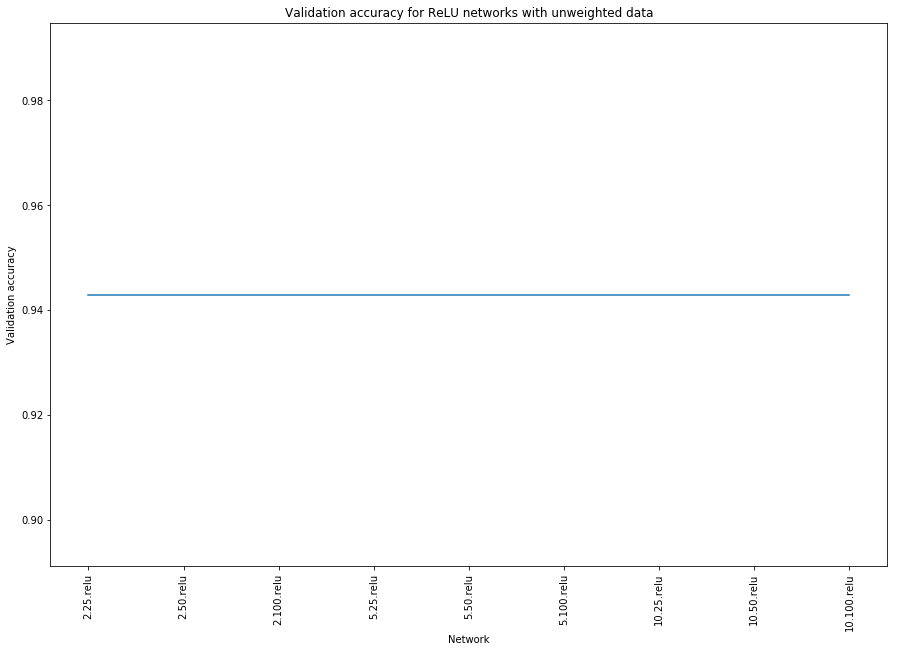

In [25]:
x=list(range(0,len(accrecord1)))
plt.plot(x,accrecord1)
plt.xticks(x,netnamesrecord1, rotation='vertical')
#plt.plot(accrecord,netnamesrecord)
plt.title('Validation accuracy for ReLU networks with unweighted data')
plt.xlabel('Network')
plt.ylabel('Validation accuracy')
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

As you can see, the validation accuracy is a flat line. It didn't improve for any of the larger networks, meaning we can keep the smallest network without losing accuracy. But did the network actually train anything? Note that the accuracy was always .94. This is very close to the proportion of bids whose 'hired' status is '0'. In fact, if we add the accuracy to the average of the 'hired' column, we get a value very close to 1. 

In [30]:
print('Acc: '+str(accrecord1))
hiredproportion=len(DF[DF['hired']==1])/len(DF)
print('Acc+fraction of hired in the dataset: '+str(accrecord1[-1]+hiredproportion))

Acc: [0.94295238095238099, 0.94295238095238099, 0.94295238095238099, 0.94295238095238099, 0.94295238095238099, 0.94295238095238099, 0.94295238095238099, 0.94295238095238099, 0.94295238095238099]
Acc+fraction of hired in the dataset: 0.999785714286


This is what we would expect if the network is just predicting '0' for everything. This would allow it to get the 'right' answer enough of the time, because the dataset is heavily weighted toward 0s (by a factor of ~15:1). Let's test that by running predictions of the finalmodel network on the set of training data where hired==1

In [33]:
hiredTrainDF=trainDF[trainDF['hired']==1]
hiredPredictionData=hiredTrainDF.drop(['hired'],axis=1).as_matrix()
# Calculate predictions: predictions
predictions1 = finalmodel1.predict(hiredPredictionData)

# Calculate predicted probability of survival: predicted_prob_true
predicted_prob_true1 = predictions1[:,1]
predicted_prob_false1 = predictions1[:,0]
print('True positives: '+str(predicted_prob_true1.mean())+'\t False negatives: '+str(predicted_prob_false1.mean()))

True positives: 0.0990437


**Result: This model is only predicting 'hired' ~6% of the time, for the 'hired' events. This means our model is giving ~93.5% false negatives.**  This is to be expected with a sparse dataset; the large number of 0 values tends to train the artificial neuron weights to produce a 0. This is why there is no difference in accuracy across the parameter search. All of our models have low variance, and high bias.

### 2.3 A larger parameter search, with class weights
The neural network is not *wrong* here, it's right, that if asked to predict from this data, it would simply conclude that most bids result in no hire. But this is useless for the objective of giving the tasker a tool to predict their best bids. So what can we do to fix it?
* According to [Andrew Ng](https://www.youtube.com/watch?v=C1N_PDHuJ6Q), you can always solve for high bias with a 'bigger network', so we can try larger network sizes.
* According to [Dan-Ching Liu](https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7), you can solve the 'dying neuron' problem with different activation functions. He suggests using leaky ReLU, eLU and a lower learning rate.
* Class balancing the training will allow us to reduce false-negatives, but will increase false-positives.


Let's see if using a bigger network, and the suggested activation functions, produces a better result. By adding these parameters to the lists we add dimensions to our parameter search. Below you can see a new `TrainAdvancedActivationNet()` function, which now accepts arguments for advanced activation layers, and `class_weight`. I set the activator functions to include LeakyReLU and ELU, and the class weight to 1:15. I then ran a combinatoric parameter search of the variables to find the highest resulting validation accuracy network. I also set the layer and node sizes of the network to be *much* larger.

In [34]:
def TrainAdvancedActivationNet(TargetDF, layers, nodes, epochs, activator, lossfcn, advanced_activator, class_weight):
	target=to_categorical(TargetDF[targetcolumn])
	predictors=TargetDF.drop([targetcolumn], axis=1).as_matrix()
	n_cols=predictors.shape[1]
	model=Sequential()
	model.add(Dense(nodes,activation=activator,input_shape=(n_cols,)))
	for layer in range(0,layers):
		if advanced_activator=='relu':
			model.add(Dense(nodes,activation=activator))
		if advanced_activator=='LeakyReLU':
			model.add(keras.layers.LeakyReLU(alpha=0.3))
		if advanced_activator=='ELU':
			model.add(keras.layers.ELU(alpha=0.3))			
	model.add(Dense(2,activation='softmax'))
	model.compile(optimizer='adam',loss=lossfcn, metrics=['categorical_accuracy'])
	model_training=model.fit(predictors,target, validation_split=0.7, epochs=epochs, shuffle=True, callbacks=[earlystopping], verbose=1, class_weight=class_weight)
	val_acc=model_training.history['val_categorical_accuracy']
	val_acc=val_acc[-1]
	return(model,val_acc)
	#return(model_training.history)

In [37]:
targetcolumn='hired'
layerslist=[10,50,100]
nodeslist=[250,500,750]
epochs=10
activator='relu'
advanced_activators=['relu','LeakyReLU','ELU'] 
lossfcn='categorical_crossentropy'
class_weight={0: 1.,1:15.}
#class_weights = [{0: 1.,1:5.},{0: 1.,1:10.},{0: 1.,1: 25.}] #we can use weights as parameters for search if you like

In [38]:
total_nets=0
targetnets=len(layerslist)*len(nodeslist)*len(advanced_activators)
targetacc=0
accrecord2=[]
targetaccrecord2=[]
netnamesrecord2=[]

#parameter search through layers and nodes values, keeping the model with the highest validation accuracy
while total_nets<targetnets:
	for layers in layerslist:
		for nodes in nodeslist:
			for advanced_activator in advanced_activators:
				net_name=(str(layers)+'.'+str(nodes)+'.'+str(advanced_activator))
				print(str(total_nets)+'/'+str(targetnets)+' complete. Next net: '+str(layers)+' layers, '+str(nodes)+' nodes, activator is '+str(advanced_activator))
				model,val_acc=TrainAdvancedActivationNet(trainDF, layers, nodes, epochs, activator, lossfcn, advanced_activator, class_weight)
				if val_acc>(targetacc): #if acc>target, name and save it and new_net=Tru
					targetacc=val_acc
					print(net_name+' improved accuracy, new target accuracy is '+str(targetacc))
					finalmodel2=model #note that we're losing the old high-bias model
					finalmodel2name=net_name
				else: 
					del model
					print('Nope')
				netnamesrecord2.append(net_name)
				accrecord2.append(val_acc)
				targetaccrecord2.append(targetacc)                
				total_nets+=1

0/27 complete. Next net: 10 layers, 250 nodes, activator is relu
Train on 9000 samples, validate on 21000 samples
Epoch 1/10
9000/9000 [==============================] - 3s - loss: 1.2810 - categorical_accuracy: 0.5088 - val_loss: 1.4647 - val_categorical_accuracy: 0.9430
Epoch 2/10
9000/9000 [==============================] - 3s - loss: 1.2497 - categorical_accuracy: 0.7287 - val_loss: 1.2439 - val_categorical_accuracy: 0.7549
Epoch 3/10
9000/9000 [==============================] - 3s - loss: 1.2564 - categorical_accuracy: 0.8557 - val_loss: 1.2419 - val_categorical_accuracy: 0.6833
Epoch 4/10
9000/9000 [==============================] - 3s - loss: 1.2376 - categorical_accuracy: 0.8068 - val_loss: 1.2427 - val_categorical_accuracy: 0.9430
Epoch 5/10
9000/9000 [==============================] - 3s - loss: 1.2534 - categorical_accuracy: 0.8706 - val_loss: 1.2439 - val_categorical_accuracy: 0.9417
Epoch 6/10
9000/9000 [==============================] - 3s - loss: 1.2390 - categorical_acc

9000/9000 [==============================] - 3s - loss: 3.3451 - categorical_accuracy: 0.6042 - val_loss: 4.1411 - val_categorical_accuracy: 0.4510
Epoch 3/10
9000/9000 [==============================] - 3s - loss: 3.7648 - categorical_accuracy: 0.5729 - val_loss: 1.5753 - val_categorical_accuracy: 0.4795
Epoch 4/10
9000/9000 [==============================] - 3s - loss: 3.7190 - categorical_accuracy: 0.6006 - val_loss: 1.7984 - val_categorical_accuracy: 0.3098
Epoch 5/10
9000/9000 [==============================] - 3s - loss: 3.2436 - categorical_accuracy: 0.5768 - val_loss: 1.8995 - val_categorical_accuracy: 0.4791
Epoch 6/10
9000/9000 [==============================] - 3s - loss: 2.8717 - categorical_accuracy: 0.5961 - val_loss: 1.9943 - val_categorical_accuracy: 0.9401
Epoch 7/10
9000/9000 [==============================] - 3s - loss: 2.7471 - categorical_accuracy: 0.5758 - val_loss: 6.1378 - val_categorical_accuracy: 0.9347
Nope
6/27 complete. Next net: 10 layers, 750 nodes, activ

9000/9000 [==============================] - 9s - loss: 3.4035 - categorical_accuracy: 0.5963 - val_loss: 5.9444 - val_categorical_accuracy: 0.1321
Epoch 2/10
9000/9000 [==============================] - 8s - loss: 2.7555 - categorical_accuracy: 0.6084 - val_loss: 1.2345 - val_categorical_accuracy: 0.6260
Epoch 3/10
9000/9000 [==============================] - 8s - loss: 2.7232 - categorical_accuracy: 0.6053 - val_loss: 6.1012 - val_categorical_accuracy: 0.9429
Epoch 4/10
9000/9000 [==============================] - 8s - loss: 2.6162 - categorical_accuracy: 0.5988 - val_loss: 3.5241 - val_categorical_accuracy: 0.2955
Epoch 5/10
9000/9000 [==============================] - 8s - loss: 2.0997 - categorical_accuracy: 0.6059 - val_loss: 5.0214 - val_categorical_accuracy: 0.9423
Epoch 6/10
9000/9000 [==============================] - 8s - loss: 2.2876 - categorical_accuracy: 0.6124 - val_loss: 1.7046 - val_categorical_accuracy: 0.9415
Nope
12/27 complete. Next net: 50 layers, 500 nodes, acti

9000/9000 [==============================] - 13s - loss: 2.9608 - categorical_accuracy: 0.5828 - val_loss: 2.3339 - val_categorical_accuracy: 0.8911
Epoch 10/10
9000/9000 [==============================] - 13s - loss: 1.9673 - categorical_accuracy: 0.6191 - val_loss: 1.3481 - val_categorical_accuracy: 0.2206
Nope
18/27 complete. Next net: 100 layers, 250 nodes, activator is relu
Train on 9000 samples, validate on 21000 samples
Epoch 1/10
9000/9000 [==============================] - 24s - loss: 1.2402 - categorical_accuracy: 0.8048 - val_loss: 1.2446 - val_categorical_accuracy: 0.9430
Epoch 2/10
9000/9000 [==============================] - 21s - loss: 1.2388 - categorical_accuracy: 0.9437 - val_loss: 1.2453 - val_categorical_accuracy: 0.9430
Epoch 3/10
9000/9000 [==============================] - 21s - loss: 1.2382 - categorical_accuracy: 0.9437 - val_loss: 1.2455 - val_categorical_accuracy: 0.9430
Epoch 4/10
9000/9000 [==============================] - 20s - loss: 1.2382 - categorical_

9000/9000 [==============================] - 106s - loss: 1.2460 - categorical_accuracy: 0.9403 - val_loss: 1.2447 - val_categorical_accuracy: 0.9430
Epoch 2/10
9000/9000 [==============================] - 103s - loss: 1.2383 - categorical_accuracy: 0.9437 - val_loss: 1.2447 - val_categorical_accuracy: 0.9430
Epoch 3/10
9000/9000 [==============================] - 104s - loss: 1.2382 - categorical_accuracy: 0.9437 - val_loss: 1.2463 - val_categorical_accuracy: 0.9430
Epoch 4/10
9000/9000 [==============================] - 102s - loss: 1.2387 - categorical_accuracy: 0.9437 - val_loss: 1.2450 - val_categorical_accuracy: 0.9430
Epoch 5/10
9000/9000 [==============================] - 102s - loss: 1.2376 - categorical_accuracy: 0.9437 - val_loss: 1.2446 - val_categorical_accuracy: 0.9430
Epoch 6/10
9000/9000 [==============================] - 102s - loss: 1.2378 - categorical_accuracy: 0.9437 - val_loss: 1.2447 - val_categorical_accuracy: 0.9430
Epoch 7/10
9000/9000 [=======================

In [39]:
finalmodel2

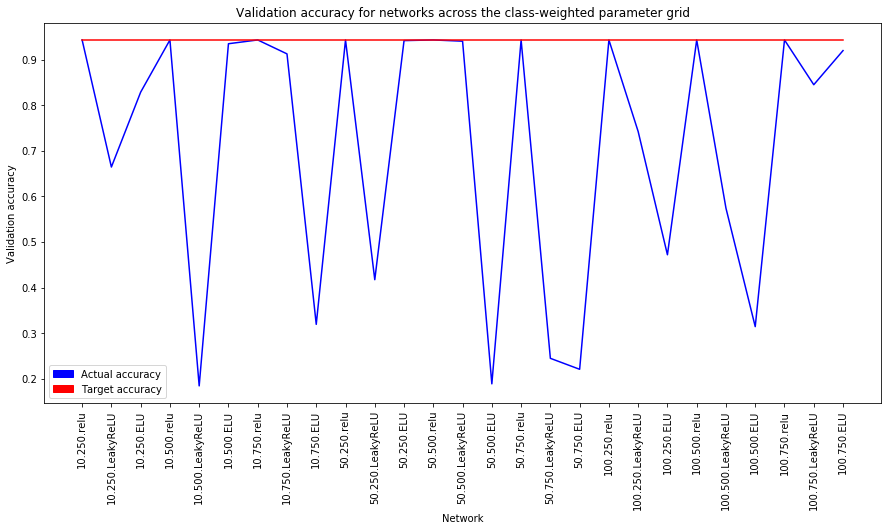

In [99]:
plt.close()
x=list(range(0,len(accrecord2)))
#plot
plt.plot(x,accrecord2, color='blue')
plt.plot(x,targetaccrecord2, color='red')
#axes
plt.xticks(x,netnamesrecord2, rotation='vertical')
plt.title('Validation accuracy for networks across the class-weighted parameter grid')
plt.xlabel('Network')
plt.ylabel('Validation accuracy')
#legend
accpatch=mpatches.Patch(color='blue', label='Actual accuracy')
targetpatch=mpatches.Patch(color='red',label='Target accuracy')
plt.legend(handles=[accpatch,targetpatch,])

plt.rcParams['figure.figsize'] = [15, 7]
plt.show()

The plot is awkward because it's functionally of a 4-dimensional pattern, but some things are clear. The first thing we notice is that the maximum accuracy was still 0.9430, which indicates that the networks might still be crashing to predict all zeroes in the highest accuracy cases. Let's test this by running the preds on the hired set as we did before:

In [50]:
#test against hiredDF
predictions2 = finalmodel2.predict(hiredPredictionData)

# Calculate predicted probability of survival: predicted_prob_true
predicted_prob_true2 = predictions2[:,1]
predicted_prob_false2 = predictions2[:,0]
print('True positives: '+str(predicted_prob_true2.mean())+'\t False negatives: '+str(predicted_prob_false2.mean()))

True positives: 0.473135	 False negatives: 0.526865


**Result:**
* The treatment greatly reduced the incidence of false negatives, but also increased the incidence of false positives.
* ReLU continued to attract toward the 0.9430 value , but without predicting all zeroes. This was surprising and indicates that it had improved its distribution of errors while preserving an awareness of the sparse dataset. The class weighting worked as expected.
* Much larger networks were not more accurate and followed the same patterns, so we don't need the very large networks, which is fine because they take quite a long time to train.
* Structuring the network **entirely** from alternate activation layers did not in itself improve performance on this task. Most literature references alternate activation layers in the context of ReLU layers, so there may well be more progress to be made by exploring these layers in mixed network architectures, outside the scope of this project.

### 2.4 Using the results of the grid search, and restricting training data to a single task category

*Once more, with feeling!* This time we're using a grid of small neural network architectures, ReLU with class weighting. Further, we're only going to train on the 'MoveDF' dataframe. If this works better with only one group, we can save a lot of entropy in the network by just giving it one category to work on, and I'm choosing the 'Moving Help' category because I've already found it to have the largest point-biserial r with its 'hired' column.

In [51]:
targetcolumn='hired'
layerslist=[10,15,20]
nodeslist=[100,150,200]
epochs=10
activator='relu'
advanced_activator='relu'
lossfcn='categorical_crossentropy'
class_weight={0: 1.,1:15.}

In [56]:
total_nets=0
targetnets=len(layerslist)*len(nodeslist)
targetacc=0 #since the attractor value above was 0.934, we're requiring networks to be above this threshold
accrecord3=[]
targetaccrecord3=[]
netnamesrecord3=[]

moveTrainDF=trainDF[trainDF['category']==2]
#parameter search through layers and nodes values, keeping the model with the highest validation accuracy
while total_nets<targetnets:
	for layers in layerslist:
		for nodes in nodeslist:
			net_name=(str(layers)+'.'+str(nodes)+'.'+str(advanced_activator))
			print(str(total_nets)+'/'+str(targetnets)+' complete. Next net: '+str(layers)+' layers, '+str(nodes)+' nodes, activator is '+str(advanced_activator))
			model,val_acc=TrainAdvancedActivationNet(trainDF, layers, nodes, epochs, activator, lossfcn, advanced_activator, class_weight)
			if val_acc>(targetacc): #if acc>target, name and save it and new_net=Tru
				targetacc=val_acc
				print(net_name+' improved accuracy, new target accuracy is '+str(targetacc))
				finalmodel3=model #note that we're losing the old high-bias model
				finalmodel3name=net_name
			else: 
				del model
				print('Nope')
			netnamesrecord3.append(net_name)
			accrecord3.append(val_acc)
			targetaccrecord3.append(targetacc)                
			total_nets+=1

0/9 complete. Next net: 10 layers, 100 nodes, activator is relu
Train on 9000 samples, validate on 21000 samples
Epoch 1/10
9000/9000 [==============================] - 6s - loss: 1.2407 - categorical_accuracy: 0.5566 - val_loss: 1.2280 - val_categorical_accuracy: 0.3252
Epoch 2/10
9000/9000 [==============================] - 4s - loss: 1.2322 - categorical_accuracy: 0.5221 - val_loss: 1.2062 - val_categorical_accuracy: 0.2410
Epoch 3/10
9000/9000 [==============================] - 4s - loss: 1.2124 - categorical_accuracy: 0.3816 - val_loss: 1.2233 - val_categorical_accuracy: 0.2144
Epoch 4/10
9000/9000 [==============================] - 4s - loss: 1.1987 - categorical_accuracy: 0.4293 - val_loss: 1.2083 - val_categorical_accuracy: 0.5095
Epoch 5/10
9000/9000 [==============================] - 4s - loss: 1.1993 - categorical_accuracy: 0.4417 - val_loss: 1.2175 - val_categorical_accuracy: 0.4853
Epoch 6/10
9000/9000 [==============================] - 4s - loss: 1.1938 - categorical_accu

9000/9000 [==============================] - 5s - loss: 1.2377 - categorical_accuracy: 0.9436 - val_loss: 1.2380 - val_categorical_accuracy: 0.9430
Epoch 4/10
9000/9000 [==============================] - 5s - loss: 11.9426 - categorical_accuracy: 0.9430 - val_loss: 13.7925 - val_categorical_accuracy: 0.9430
Epoch 5/10
9000/9000 [==============================] - 5s - loss: 13.6198 - categorical_accuracy: 0.9437 - val_loss: 13.7925 - val_categorical_accuracy: 0.9430
Epoch 6/10
9000/9000 [==============================] - 5s - loss: 13.6198 - categorical_accuracy: 0.9437 - val_loss: 13.7925 - val_categorical_accuracy: 0.9430
Epoch 7/10
9000/9000 [==============================] - 5s - loss: 13.6198 - categorical_accuracy: 0.9437 - val_loss: 13.7925 - val_categorical_accuracy: 0.9430
Nope
7/9 complete. Next net: 20 layers, 150 nodes, activator is relu
Train on 9000 samples, validate on 21000 samples
Epoch 1/10
9000/9000 [==============================] - 11s - loss: 1.2515 - categorical_a

In [57]:
accrecord3

[0.83738095238095234,
 0.32561904761904764,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099,
 0.94295238095238099]

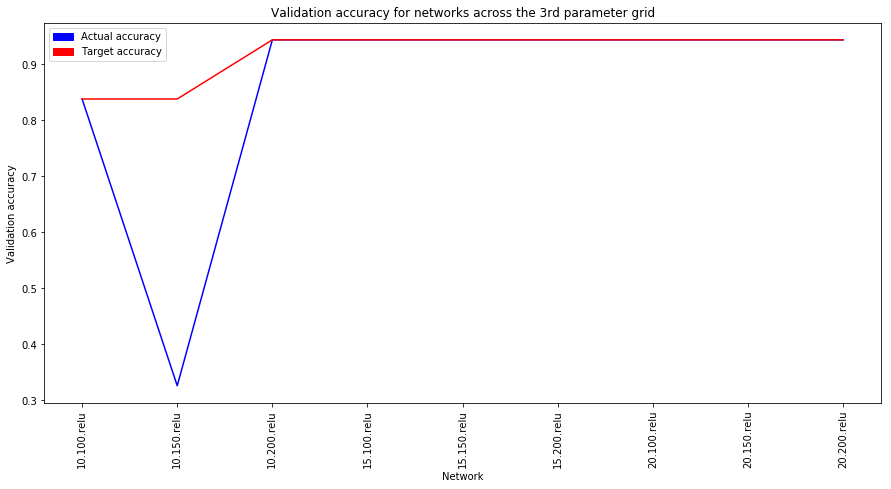

In [100]:
plt.close()
x=list(range(0,len(accrecord3)))
#plot
plt.plot(x,accrecord3, color='blue')
plt.plot(x,targetaccrecord3, color='red')
plt.xticks(x,netnamesrecord3, rotation='vertical')
#axes
plt.title('Validation accuracy for networks across the 3rd parameter grid')
plt.xlabel('Network')
plt.ylabel('Validation accuracy')
#legend
accpatch=mpatches.Patch(color='blue', label='Actual accuracy')
targetpatch=mpatches.Patch(color='red',label='Target accuracy')
plt.legend(handles=[accpatch,targetpatch])

plt.rcParams['figure.figsize'] = [15, 7]
plt.show()

In [60]:
finalmodel3name

'10.200.relu'

Let's consider the false positives ratio, as we've done before:

In [61]:
#test against hiredDF
predictions3 = finalmodel3.predict(hiredPredictionData)

# Calculate predicted probability of survival: predicted_prob_true
predicted_prob_true3 = predictions3[:,1]
predicted_prob_false3 = predictions3[:,0]
print('True positives: '+str(predicted_prob_true2.mean())+'\t False negatives: '+str(predicted_prob_false2.mean()))

True positives: 0.473135	 False negatives: 0.526865


**Result:**
* This approach greatly reduced the training time and simplified the network used, but preserved the positive result bias.
* Within this range, all configurations with >=15 layers found the 0.943 balance point.

## 3. Implementing the produced neural network as a useful product feature for taskers

Given these predictors, we can automate prediction of a hired/not-hired probability, given the tasker's typical position in the job type for which they are bidding. Because the only variable in the tasker's control is  hourly_rate, we vary it experimentally across the expected range of bids, for the variables of the given tasker. We can then plot the result to show the tasker their likelihood of hire success, given different hourly_rates.

Recall that the trainingDF form looks like this:

In [62]:
trainDF[:5]

,hourly_rate,num_completed_tasks,hired,category,meanrate,maxrate,meancomp,maxcomp
0,38,151,0,2,1.144578,0.76,1.281109,0.165208
1,40,193,0,2,1.204819,0.80,1.637443,0.211160
2,28,0,0,2,0.843373,0.56,0.000000,0.000000
3,43,303,0,2,1.295181,0.86,2.570701,0.331510
4,29,39,0,2,0.873494,0.58,0.330882,0.042670


There are several independent variables, but a given tasker can't change their number of completed tasks, only their hourly_rate. Therefore we define the variables as follows:  
* **hourly_rate**: we take the mean and standard deviation of the hourly_rate for the category, and run from -1SD to +1SD, in 10 increments
* **num_completed_tasks**: we can take the maximum num_completed_tasks for that tasker
* **category**: We have to pick a category type. Because the hourly rate is the strongest predictor for the 'Moving Help' category, here I'll select a tasker only from the 'Moving Help' category.
* **meanrate, maxrate, meancomp, maxcomp**: We can determine the mean and max hourly_rate and num_completed from the category, which will give the likely position of the tasker in a randomly ordered recommendation.


In [67]:
# get a random tasker's uuid: tasker_id
randomUUID=random.sample(set(moveDF.tasker_id),1)[0]
taskerDF=DF[DF['tasker_id']==randomUUID]

while True:
    if (len(taskerDF)>5)&(taskerDF.hired.sum()!=0): #select for taskers with multiple attempts, and at least one success
        break
    else:
        randomUUID=random.sample(set(moveDF.tasker_id),1)[0]
        taskerDF=DF[DF['tasker_id']==randomUUID]

len(taskerDF)
taskerDF

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category,meanrate,maxrate,meancomp,maxcomp
2847,0-0-7ea009be-705f-4850-9569-4284753b5de8,2017-09-04 23:22:10,1013252925,3,80,35,0,Moving Help,0.604534,0.400000,0.074701,0.029966
2862,0-0-616f3ce1-8fa2-4115-86db-ae261d0a3ee8,2017-09-04 23:22:14,1013252925,3,80,35,0,Moving Help,0.618557,0.400000,0.078663,0.029966
3249,0-0-045332f6-2725-4b75-a026-c7176b0e7248,2017-09-05 15:16:11,1013252925,13,80,35,0,Moving Help,1.232033,0.842105,0.155556,0.032957
3527,0-0-20a9e29c-2201-40e1-9e11-2c92653831c6,2017-09-05 17:41:17,1013252925,3,80,35,0,Moving Help,0.689655,0.400000,0.080165,0.029915
3902,0-0-313cd31e-8269-45a1-a37a-cffa860e10ca,2017-09-05 21:07:22,1013252925,3,80,35,0,Moving Help,0.707965,0.400000,0.078183,0.029889
5058,0-0-1c38383d-6758-40c2-864d-c998851620b4,2017-09-06 20:10:40,1013252925,5,80,35,0,Moving Help,0.785340,0.400000,0.085491,0.029889
5205,0-0-536865eb-2279-4fe0-830c-32960200d198,2017-09-06 22:48:16,1013252925,4,80,35,0,Moving Help,0.777706,0.400000,0.087122,0.029889
5235,0-0-239b3649-6ebd-4c2f-9291-468c13742d90,2017-09-06 22:48:59,1013252925,4,80,35,0,Moving Help,0.753296,0.400000,0.103346,0.032957
5279,0-0-47831bb5-42e5-49bf-a3b2-f28bf89e38a2,2017-09-06 22:50:33,1013252925,3,80,35,0,Moving Help,0.741656,0.400000,0.076486,0.029889
5520,0-0-243fcce1-3720-4965-98c3-f34f3efbf9c6,2017-09-07 10:50:48,1013252925,4,80,35,0,Moving Help,0.708801,0.400000,0.104312,0.032957


In [68]:
# what range of hourly_rates do we use? The mean of the category, +/- 1SD
meanrate=moveDF.hourly_rate.mean()
maxRangeRate=meanrate+moveDF.hourly_rate.std()
minRangeRate=meanrate-moveDF.hourly_rate.std()
rateslist=list(np.linspace(minRangeRate,maxRangeRate,10))
print(rateslist)

[32.341733255067304, 43.49979253171901, 54.657851808370722, 65.815911085022435, 76.973970361674134, 88.132029638325832, 99.290088914977559, 110.44814819162926, 121.60620746828096, 132.76426674493268]


In [69]:
# also calculate that tasker's bid as a ratio with meanrate, maxrate, meancomp and maxcomp for their category

meanrate=moveDF.hourly_rate.mean()
maxrate=moveDF.hourly_rate.max()
meancomp=moveDF.num_completed_tasks.mean()
maxcomp=moveDF.num_completed_tasks.max()

meanRateList=[]
maxRateList=[]
meancompList=[]
maxcompList=[]

t_comp=taskerDF.num_completed_tasks.max()
t_meancomp=t_comp/meancomp
t_maxcomp=t_comp/maxcomp
num_completed_tasksList=[t_comp]*10
categorylist=[2]*10

for rate in rateslist:
    meanRateList.append(rate/meanrate)
    maxRateList.append(rate/maxrate)
    meancompList.append(t_meancomp) #these are fixed because the c
    maxcompList.append(t_maxcomp)

taskerTrainDF=pd.DataFrame()
taskerTrainDF['hourly_rate']=rateslist
taskerTrainDF['num_completed_tasks']=num_completed_tasksList
taskerTrainDF['category']=categorylist
taskerTrainDF['meanrate']=meanRateList
taskerTrainDF['maxrate']=maxRateList
taskerTrainDF['meancomp']=meancompList
taskerTrainDF['maxcomp']=meancompList
taskerTrainDF

,hourly_rate,num_completed_tasks,category,meanrate,maxrate,meancomp,maxcomp
0,32.341733,35,2,0.391769,0.129367,0.135868,0.135868
1,43.499793,35,2,0.526932,0.173999,0.135868,0.135868
2,54.657852,35,2,0.662094,0.218631,0.135868,0.135868
3,65.815911,35,2,0.797256,0.263264,0.135868,0.135868
4,76.973970,35,2,0.932419,0.307896,0.135868,0.135868
5,88.132030,35,2,1.067581,0.352528,0.135868,0.135868
6,99.290089,35,2,1.202744,0.397160,0.135868,0.135868
7,110.448148,35,2,1.337906,0.441793,0.135868,0.135868
8,121.606207,35,2,1.473068,0.486425,0.135868,0.135868
9,132.764267,35,2,1.608231,0.531057,0.135868,0.135868


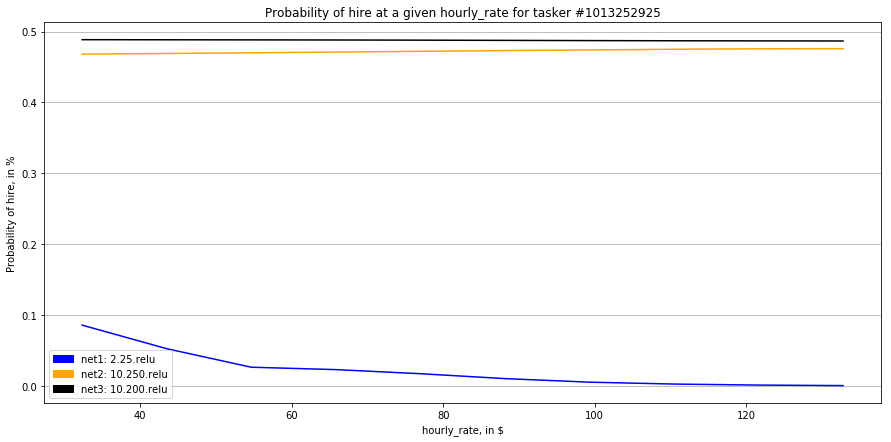

In [101]:
plt.close()
# Calculate predictions from the query:
predictors=taskerTrainDF.as_matrix()
predictions1 = finalmodel1.predict(predictors)[:,1]
predictions2 = finalmodel2.predict(predictors)[:,1]
predictions3 = finalmodel3.predict(predictors)[:,1]

# plot the result with hourly_rate as independent var(x-axis) and likelihood of hire as dependent var(y-axis)
plt.plot(list(taskerTrainDF['hourly_rate']),list(predictions1), color='blue')
plt.plot(list(taskerTrainDF['hourly_rate']),list(predictions2), color='orange')
plt.plot(list(taskerTrainDF['hourly_rate']),list(predictions3), color='black')

plt.title('Probability of hire at a given hourly_rate for tasker #'+str(randomUUID))
plt.xlabel('hourly_rate, in $')
plt.ylabel('Probability of hire, in %')
plt.grid(axis='y')
#legend
net1patch=mpatches.Patch(color='blue',label='net1: '+finalmodel1name)
net2patch=mpatches.Patch(color='orange', label='net2: '+finalmodel2name)
net3patch=mpatches.Patch(color='black',label='net3: '+finalmodel3name)
plt.legend(handles=[net1patch,net2patch,net3patch])
plt.rcParams['figure.figsize'] = [15, 7]
plt.show()

As expected, the first tiny network has a very strong bias toward not-hired predictions.. Let's plot the latter two, without so many false negatives:

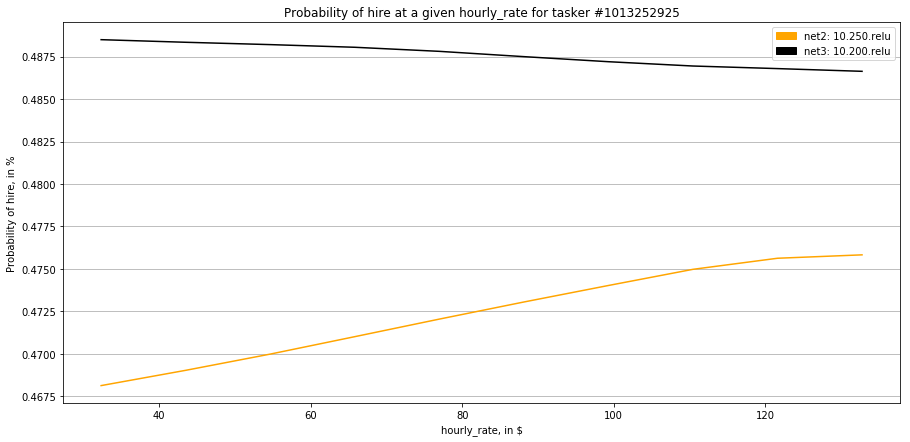

In [102]:
plt.close()
# plot the result with hourly_rate as independent var(x-axis) and likelihood of hire as dependent var(y-axis)
plt.plot(list(taskerTrainDF['hourly_rate']),list(predictions2), color='orange')
plt.plot(list(taskerTrainDF['hourly_rate']),list(predictions3), color='black')

plt.title('Probability of hire at a given hourly_rate for tasker #'+str(randomUUID))
plt.xlabel('hourly_rate, in $')
plt.ylabel('Probability of hire, in %')
plt.grid(axis='y')
#legend
net2patch=mpatches.Patch(color='orange', label='net2: '+finalmodel2name)
net3patch=mpatches.Patch(color='black',label='net3: '+finalmodel3name)
plt.legend(handles=[net2patch,net3patch])
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

**Result:**
net3 shows the negative correlation with `hourly_rate`, and net2 shows a positive correlation. Because we know from earlier that the point-biserial r between `hourly_rate` and `hired` is negative, **we can reject the net2 model.**

* net3 was trained on the category specifically, and net2 was trained on the general dataset. It seems likely that this affects the strange outcome above.
* More specifically: we already knew the highest point-biserial-r to 'hired' in 2/3 of the categories was with the `num_completed_tasks` variable. Because of this, taskers with a high number of completed tasks have a small partial monopoly on hires for these job categories. 
* Since the bid a tasker makes in those cases is closely associated with their expectation of hire, and the expectation of hire is closely associated with number of completed tasks, **net2 detected a general association between `hourly_rate` and `hired`.**

Therefore, net3 is better suited for this prediction, because it's trained only on this category. Let's plot using net3 only:

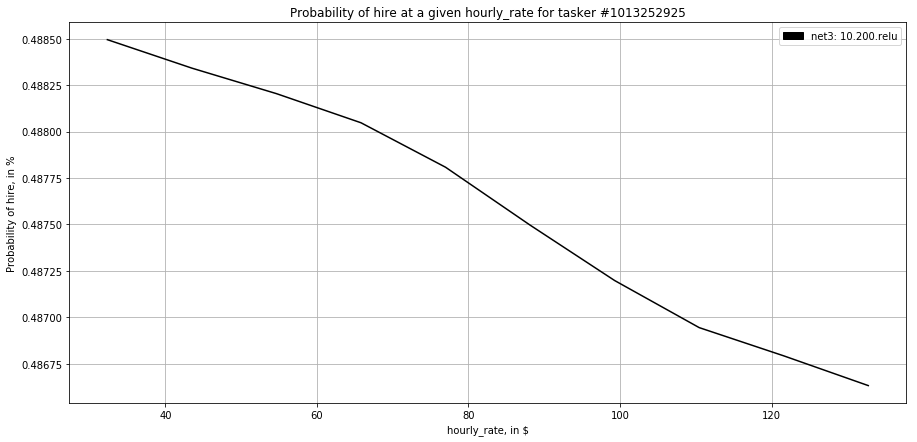

In [104]:
plt.close()
# plot the result with hourly_rate as independent var(x-axis) and likelihood of hire as dependent var(y-axis)
plt.plot(list(taskerTrainDF['hourly_rate']),list(predictions3), color='black')

plt.title('Probability of hire at a given hourly_rate for tasker #'+str(randomUUID))
plt.xlabel('hourly_rate, in $')
plt.ylabel('Probability of hire, in %')
plt.grid(axis='y')
plt.grid(axis='x')
#legend
net3patch=mpatches.Patch(color='black',label='net3: '+finalmodel3name)
plt.legend(handles=[net3patch])
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

This is the result which most closely fits my intuitions about this function: roughly sigmoidal, and negatively correlated with `hourly_rate`. Even still, the range of prediction over which it occurs seems smaller than likely. This is because we've heavily class-weighted the neural networks to produce this ratio of false-positives, to avoid the negatives we saw in net1 above.

In [84]:
plt.close()

### 4. Conclusion

* It is possible to use this data to predict hired/not-hired bids from a tasker's `hourly_rate`. The likelihood still favors not-hired at ~14:1, but we can give a tasker a way to optimize their performance within that range.
* The neural networks which predict these variables successfully do not have to be large, but they should be class-weighted.
* The flatness of the plot of predictions makes me think it might be possible to replace the neural networks with a simple 3-variable polynomial curve fit (or sigmoidal curve fit), but that's outside the scope of this project.
* This project could probably use weeks more of work, but the due date looms. :)